In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# The usual notebook preferences

%config InlineBackend.figure_format = 'svg'

import numpy
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
from helper_functions import *

HTML(toggle_code("import functions"))

<IPython.core.display.HTML object>

In [3]:
set_notebook_preferences()

## 3.5 Bayesian logistic regression

Previously, in [section 3.3](classification_multiclass.ipynb), we have been using gradient ascent to find weights $\mathbf{w}$ which maximise the log-likelihood $\mathcal{L}$. However this is not the only approach, and we now turn to a Bayesian treatment of logistic regression. Re-iterating our recipe for Bayesian approaches:

1. Write down the likelihood $p(\mathcal{D}|\mathbf{w})$ of the generative model.
2. Assume a prior $p(\mathbf{w})$ over the parameter(s) of the model.
3. Apply Bayes' rule to find the posterior $p(\mathbf{w}|\mathcal{D})$.
4. Calculate the predictive distribution $p(y^*| \mathcal{D})$.

We have already looked at step 1 here; this is just the likelihood of the complete dataset. Regarding the prior (step 2), in the regression example we picked a gaussian conjugate prior, in order to aid calculations down the line. Here however, the form of the likelihood makes exact inference intractable $-$ that's why we used gradient ascent $-$ and it is not possible to find a prior conjugate to this likelihood. Let us then assume an isotropic gaussian prior with mean $0$ and covariance matrix $\boldsymbol{\Sigma}_0 = \lambda I$ over the model weights. Step 3 is now more challenging than in regression where the gaussian form of the likelihood and prior gave an exact closed form for the posterior, so our calculation will need to be approximate. There are several ways to go about this approximation, one of which is to use the Laplace approximation which amounts to approximating the likelihood using a multivariate gaussian. The approximate posterior will then also be gaussian, and from there we will be able to obtain the predictive distribution $p(y^*| \mathcal{D})$ in step 4. To summarise, for logistic regression our approach will be

1. Likelihood $p(\mathcal{D}|\mathbf{w})$ as obtained already.
2. Assume a gaussian prior $\mathcal{N}(\mathbf{w}; 0, \boldsymbol{\Sigma}_0)$.
3. Apply the Laplace approximation $p(\mathcal{D}|\mathbf{w}) \approx \mathcal{N}(\mathbf{w}; \boldsymbol{\mu}, \boldsymbol{\Sigma})$ and use it to calulate an approximation of the posterior $p(\mathbf{w}|\mathcal{D})$.
4. Calculate the approximate predictive distribution $p(y^*| \mathcal{D})$.

## Laplace approximation

Consider a distribution $p(z)$ with its mode at $z_0$. Expanding the logarithm of $p(z)$ using a Taylor expansion, remembering that the linear term will vanish because we are at a maximum:

\begin{align}
\text{log}~p(z) \approx \text{log}~p(z_0) + \frac{1}{2}(z - z_0)^2\frac{d^2}{dz^2}\text{log}~p(z)
\end{align}

The Laplace approximation of $p(z)$ is the gaussian which has its mean at the mode of $p(z)$, and a variance $\sigma^2$ to match the quadratic coefficient of the above expansion. For a gaussian we have

\begin{align}
\text{log}~\mathcal{N}(z; z_0, \sigma^2) = \text{const. } - \frac{1}{2\sigma^2}(z - z_0)^2
\end{align}

so we will pick $1/\sigma^2 = - \frac{d^2}{dz^2}\text{log}~p(z)$, so that the second-order term of the (exact) expansion of the gaussian matches the corresponding term in the approximate expansion of $p(x)$. Let's work through the example distribution

\begin{align}
p(z) = \frac{a}{\pi}\frac{1}{a^2 + z^2}~\text{ (already normalised).}
\end{align}

The mode of this distribution is at $z = 0$ and the second derivative at $z = 0$ is

\begin{align}
\frac{d^2 p(z)}{dz^2} = \bigg[ \frac{4z^2}{(a^2 + z^2)^2} - \frac{2}{a^2 + z^2} \bigg]_{z = 0} = -\frac{2}{a^2}
\end{align}

Therefore the Laplace approximation of this distribution is a gaussian with its mean at 
$0$ and a variance $\sigma^2 = a^2/2$:

$$
\mathcal{N}(z; 0, a^2/2)
$$

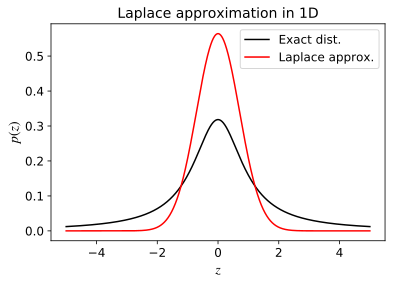

<IPython.core.display.HTML object>

In [4]:
a = 1
z_ = np.linspace(-5, 5, 1000)
p_ = a/(np.pi * (a**2 + z_**2))
gaussian = 1/(np.pi*a**2)**0.5 * np.exp(-1/a**2*z_**2)

plt.plot(z_, p_, color = 'black', label = 'Exact dist.')
plt.plot(z_, gaussian, color = 'red', label = 'Laplace approx.')
beautify_plot({"title":r"Laplace approximation in 1D", "x":"$z$", "y":"$p(z)$"})
plt.gca().legend(fontsize = 12)
plt.show()

HTML(toggle_code())

** add laplace approximation examples**

In this example, the approximating gaussian decays as $e^{-z^2}$ whereas the exact distribution decays much slower, as $1/(z^2)$. Since both distributions must be normalised, this means that the Laplace approximation must have a higher peak than the example distribution, the later being more spread out along the x-axis.

For a multivariate distribution $p(\mathbf{z})$, the Laplace approximation is a multivariate gaussian. We pick the mean of the approximating gaussian to be the mode of the exact distribution. The covariance matrix is again given in terms of the expansion of $\text{log}~p(\mathbf{z})$:

\begin{align}
\text{log}~p(\mathbf{z}) &\approx \text{log}~p(\mathbf{z}_0) + \frac{1}{2}\sum_i\sum_j (z_j - z_{0i})^2\frac{d}{dz_i}\frac{d}{dz_j}\text{log}~p(x)\\
~\\
&= \text{log}~p(\mathbf{z}_0) + \frac{1}{2} (\mathbf{z} - \mathbf{z}_0)^\top \bigg[\nabla \nabla \text{log}~p(x)\bigg] (\mathbf{z} - \mathbf{z}_0)\\
\end{align}

In the case of a multivariate gaussian:

\begin{align}
\text{log}~q(\mathbf{z}) = \text{const. } - \frac{1}{2} (\mathbf{z} - \mathbf{z}_0)^\top \boldsymbol{\Sigma}^{-1} (\mathbf{z} - \mathbf{z}_0)\\
\end{align}

So comparing the two expansions we obtain

\begin{align}
\boldsymbol{\Sigma}^{-1} = -\nabla \nabla \text{log}~p(x).\\
\end{align}

The matrix $\nabla \nabla \text{log}~p(x)$ is a Hessian Matrix (a matrix containing the double derivatives of a quantity as its entries) and is often referred to by this name.

## Laplace approximation applied to Bayesian logistic regression

To apply the Laplace approximation to the posterior, we need to determine the mode of the posterior and calculate the Hessian at that mode. The exact solution to the maximum of the posterior is intractable, but we can use gradient ascent to approximate the mode of the posterior as we did with the likelihood $-$ the only difference being that in the posterior there will be a term from the pior in the expression we are maximizing. Using a gaussian prior $\mathcal{N}(\mathbf{w}; \mathbf{m}_0, \boldsymbol{\Sigma}_0)$ we can write the logarithm of the posterior using Bayes rule:

\begin{align}
p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &\propto p(\{\mathbf{y}_n, \mathbf{x}_n\} | \mathbf{w}) p(\mathbf{w})\\
~\\
\text{log}~p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &= -\frac{1}{2} (\mathbf{w} - \mathbf{m}_0)^\top \boldsymbol{\Sigma}^{-1}_0(\mathbf{w} - \mathbf{m}_0) + \sum^N_{n = 1} y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\\
~\\
\nabla \text{log}~p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &= -\boldsymbol{\Sigma}^{-1}_0(\mathbf{w} - \mathbf{m}_0) + \sum^N_{n = 1} \big(y_n - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n\\
~\\
\boldsymbol{\Sigma}^{-1} = -\nabla \nabla \text{log}~p(\mathbf{w}| \{\mathbf{y}_n, \mathbf{x}_n\}) &= \boldsymbol{\Sigma}^{-1}_0 + \sum^N_{n = 1} \sigma(\mathbf{w}^\top\mathbf{x}_n)\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n \mathbf{x}_n^\top\\
\end{align}

The Laplace approximation then takes the form $\mathcal{N}(\mathbf{w}; \mathbf{w}_{MAP}, \boldsymbol{\Sigma})$. We can now evaluate the predictive distribution:

\begin{align}
p(y^* = 1| \mathbf{x}^*, \{y_n, \mathbf{x}_n\}) &= \int p(y^* = 1| \mathbf{x}^*, \mathbf{w}) p(\mathbf{w} | \{y_n, \mathbf{x}_n\})d\mathbf{w} = \int \sigma(\mathbf{w}^\top\mathbf{x}) p(\mathbf{w} | \{y_n, \mathbf{x}_n\})d\mathbf{w}\\
&\approx \int \sigma(\mathbf{w}^\top\mathbf{x}) q(\mathbf{w})d\mathbf{w}\\
&= \int \int \sigma(a)\delta(a - \mathbf{w}^\top\mathbf{x})da~q(\mathbf{w})d\mathbf{w}\\
&= \int \sigma(a)p(a)da, \text{ where }~p(a) = \int \delta(a - \mathbf{w}^\top\mathbf{x})q(\mathbf{w})d\mathbf{w}\\
\end{align}

Our expression for distribution $p(a)$ can be simplified by noting that the Dirac-delta $\delta(a - \mathbf{w}^\top\mathbf{x})$ imposes a linear constraint on $\mathbf{w}$ so the effect of the integral $\int \delta(a - \mathbf{w}^\top\mathbf{x}) q(\mathbf{w}) d\mathbf{w}$ is to integrate out $\mathbf{w}$ along all directions orthogonal to $\mathbf{x}$. Since a marginal of a gaussian is also a gaussian the resulting distribution $p(a)$ will also be gaussian, and it suffices to find its mean and variance to fully characterise it:


\begin{align}
\mu_a &= \int a p(a) da = \int a \int \delta(a - \mathbf{w}^\top\mathbf{x}) q(\mathbf{w}) d\mathbf{w} da = \int  \mathbf{w}^\top\mathbf{x} q(\mathbf{w}) d\mathbf{w} = \mathbf{w}_{MAP}^\top\mathbf{x}\\
~\\
\sigma_a^2 &= \int \big(a^2 - \mu_a^2\big)p(a) da = \int \big(a^2 - \mu_a^2\big)\delta(a - \mathbf{w}^\top\mathbf{x})q(\mathbf{w}) d\mathbf{w} da = \int \big((\mathbf{w}^\top\mathbf{x})^2 - (\mathbf{w}_{MAP}^\top\mathbf{x})^2\big)q(\mathbf{w}) d\mathbf{w}\\
&= \int (\mathbf{w}^\top\mathbf{x})^2 q(\mathbf{w}) d\mathbf{w} - \mathbf{x}^\top\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top\mathbf{x}\\
&= \mathbf{x}^\top \bigg[\int\mathbf{w}\mathbf{w}^\top q(\mathbf{w}) d\mathbf{w} \bigg]\mathbf{x} - \mathbf{x}^\top\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top\mathbf{x}\\
&= \mathbf{x}^\top\bigg[\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top + \Sigma \bigg] \mathbf{x} - \mathbf{x}^\top\mathbf{w}_{MAP}\mathbf{w}_{MAP}^\top\mathbf{x}\\
&= \mathbf{x}^\top\Sigma\mathbf{x}
\end{align}

Therefore $p(a) = \mathcal{N}(a; \mathbf{w}_{MAP}, \mathbf{x}^\top\Sigma\mathbf{x})$. Still the integral $\int \sigma(a)\mathcal{N}(a; \mathbf{w}_{MAP}, \mathbf{x}^\top\Sigma\mathbf{x})da$ is the convolution of a sigmoid with a gaussian and cannot be evaluated explicitly, so another approximation must be made. In particular, approximating the sigmoid using the probit function:

$$\sigma(a) \approx \Phi(\lambda a) = \int_{-\infty}^{\lambda a} \mathcal{N}(z|0, 1) dz$$

where the scaling constant $\lambda$ is picked such that the gradients of $\sigma(a)$ and $\Phi(\lambda a)$ are equal at the origin:

<div class="row">
  <div class="column">
    <img src="logit_probit_scaled.svg" alt="Snow" style="width:50%; float: center; padding: 0px">
  </div>
</div>

This approximation does not appear to be very severe; the scaled probit and sigmoid seem to be quite similar. Under this approximation, it can be shown that the predictive distribution integral is equal to another scaled probit:

\begin{align}
\int \sigma(a)\mathcal{N}(a; \mu, \sigma^2)da &\approx \int \Phi(\lambda a)\mathcal{N}(a; \mu, \sigma^2)da\\
&= \Phi\Bigg(\frac{\mu}{(\lambda^{-2} + \sigma^2)^{1/2}}\Bigg), \text{ where } \mu = \mathbf{w}_{MAP}^\top \mathbf{x}, ~\sigma^2 = \mathbf{x}^\top\Sigma\mathbf{x}\\
\end{align}

Let's apply this Bayesian approach on the $1$D example we saw previously to visualise the prior, likelihood and posterior distsributions.

In [5]:
def sig(x):
    
    return 1/(1 + np.exp(-x)) # define logistic function for convenience

def gradient_ascent(x, y, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
    
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        
        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks) 

HTML(toggle_code("gradient ascent function"))

<IPython.core.display.HTML object>

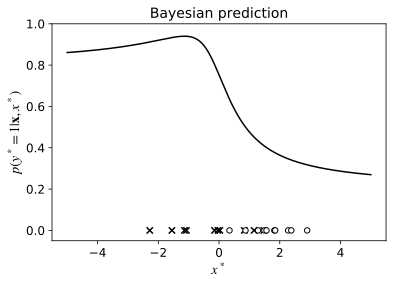

<IPython.core.display.HTML object>

In [6]:
x = np.load('class_1d_inputs.npy')
y = np.load('class_1d_labels.npy')
x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]

w_history, log_liks = gradient_ascent(x_train, y_train, np.zeros(shape = 1 + x.shape[-1]), 10**2, 1)
w_map = w_history[-1]

x_ = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = -1)
sigs = sig(x_.dot(w_map))
cov_0 = np.eye(2)*1
cov = cov_0 + (sigs*(1 - sigs)*x_.T).dot(x_)

xs = np.stack([np.ones(shape = (2000,)), np.linspace(-5, 5, 2000)], axis = 1)
mu = xs.dot(w_map)
var = np.sum((xs).dot(cov)*xs, axis = -1)

from scipy.stats import norm
probit = norm.cdf(xs)
probit_scaled = norm.cdf(mu/(8/np.pi + var)**0.5)

x_1, x_2 = x_train[np.where(y_train == 0)[0]], x_train[np.where(y_train == 1)[0]]
plt.scatter(x_1, np.zeros_like(x_1), color = 'white', edgecolor = 'black', marker = 'o', s = 30,
            zorder = 2, label = '$y = 0$')
plt.scatter(x_2, np.zeros_like(x_2), color = 'black', marker = 'x', s = 40, zorder = 1, label = '$y = 1$')
plt.plot(xs[:, 1], probit_scaled, color = 'black')
beautify_plot({"title":r"Bayesian prediction", "x":"$x^*$", "y":"$p(y^* = 1|\mathbf{x}, x^*)$"})
plt.ylim([-0.05, 1])
plt.show()

HTML(toggle_code())

Having covered bayesian logistic regression, you should now understand:

1. How to approach logistic regression from a Bayesian view of probability.
2. What a Laplace approximation is
3. How to apply a Laplace approximation in the context of Bayesian logistic regression

In [section 4](../dimensionality_reduction/dimension_intro) dimensionality we will look at dimensionality recution.